In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LeakyReLU

from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()


data_file = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [2]:
df_ru = data_file.parse(0)
df_tur = data_file.parse(1)
df_eg = data_file.parse(2)
df_bra = data_file.parse(3)
df_arg = data_file.parse(4)
df_col = data_file.parse(5)
df_sa = data_file.parse(6)
df_sk = data_file.parse(7)

In [4]:
df_arg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      301 non-null    object 
 1   Price     301 non-null    object 
 2   Open      301 non-null    object 
 3   High      301 non-null    object 
 4   Low       301 non-null    object 
 5   Vol.      300 non-null    object 
 6   Change %  300 non-null    float64
dtypes: float64(1), object(6)
memory usage: 16.6+ KB


In [5]:
def timeseries_preprocessing(df):
    #Drop the last row of the dataframe
    df.drop([df.shape[0]-1], axis=0, inplace=True)
    
    # Search if there is K instead of M in volume colum
    k_data = df[df['Vol.'].astype(str).str.contains('K')]
    df = df[df["Vol."].str.contains("K") == False]
    
    #replace with K with nothing and change it to numeric value
    k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
    k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
    
    # convert it to M by dividing it by 1000
    k_data['Vol.'] = [(i/1000) for i in k_data['Vol.']]
    
    #join the two dataframe
    df = pd.concat([df, k_data], join="inner")
    
    # remove the (M) and (-) characters
    df['Vol.'] = df['Vol.'].str.replace('M', '').replace('-', '')
    
    # fix the Date column data type to be in a date format instead of object
    df[["Date"]] = df[["Date"]].apply(pd.to_datetime)
    
    # change the Price and other columns data type to int
    df[["Price", "Open", "High", "Low", "Change %", 'Vol.']] = df[["Price", "Open", "High", "Low", "Change %", 'Vol.']].apply(pd.to_numeric)
    
    # make the index equal to Date values
    df = df.sort_values(by=['Date'], ascending=True)  
    
    df = df.drop(columns =['Vol.','Change %'])

    return df

# Argentina - Pampa Energia SA

In [6]:
df = timeseries_preprocessing(df_arg)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 299 to 0
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    300 non-null    datetime64[ns]
 1   Price   300 non-null    float64       
 2   Open    300 non-null    float64       
 3   High    300 non-null    float64       
 4   Low     300 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 14.1 KB


<ipython-input-5-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-5-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-5-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [7]:
def timeseries_plot(df):
    indexed_dataset = df.set_index('Date')
    indexed_dataset[['Price','Open','High','Low']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Values($)',fontsize=20);
    plt.title('Timeseries Plot of High, Low, Open, Closing Price of Stocks',fontsize = 20)
    plt.show() 

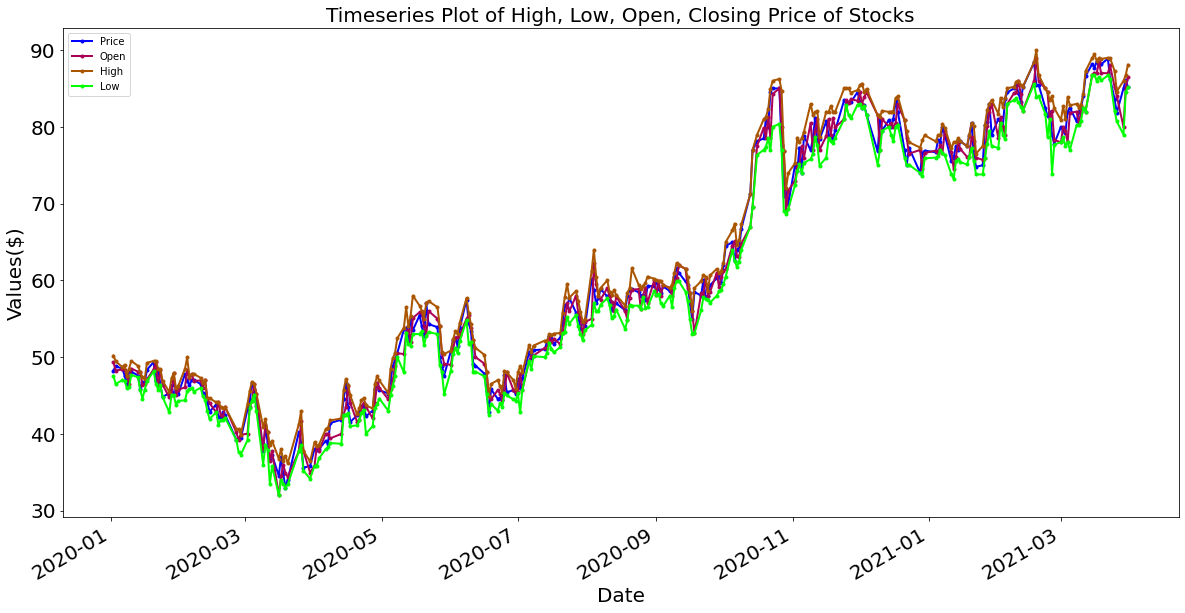

In [8]:
timeseries_plot(df)

In [9]:
def timeseries_plot_closing_value(df):
    
    indexed_dataset = df.set_index('Date')
    indexed_dataset['Price'].plot(figsize=(12,5))
    plt.xlabel('Date',fontsize=20);
    plt.ylabel('Closing Value($)',fontsize=20);
    plt.title('Timeseries of closing stock Price',fontsize = 20)
    plt.show()
    

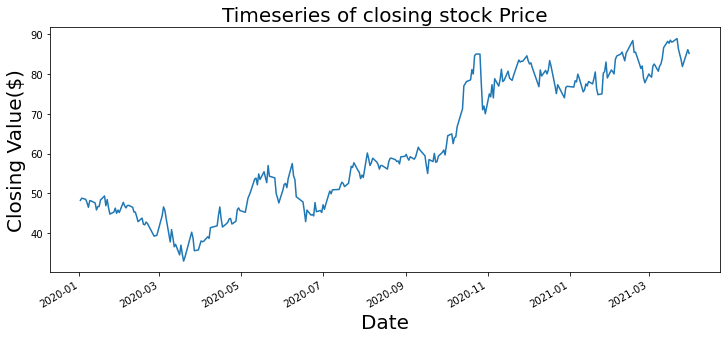

In [10]:
timeseries_plot_closing_value(df)

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
def acf_pacf_plot(df):
    indexed_dataset = df.set_index('Date')
    df_close= indexed_dataset['Price']
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(df_close,lags=20,ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(df_close,lags=20,ax=ax2)


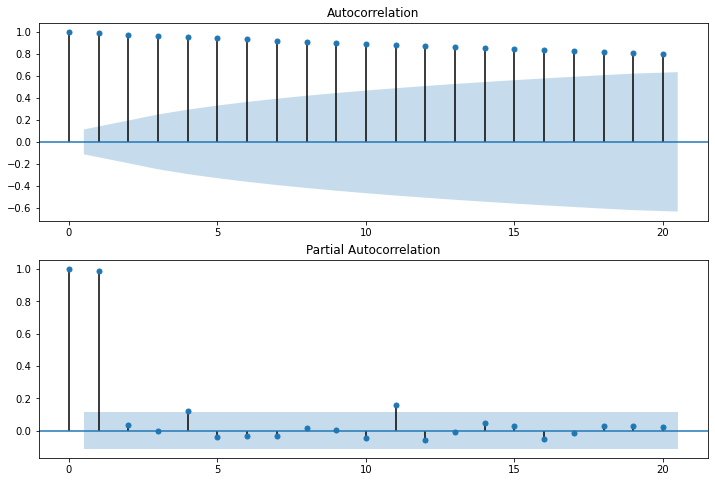

In [12]:
acf_pacf_plot(df)

# Dickey Fuller Test

In [13]:
#If the dataset is not stationary--

def stationary(df):
    result = adfuller(df.Price.values, autolag='AIC')
    if result[1] > 0.05:
        print(f'The p-value is {result[1]} reject the null hypthesis and data is not stationary')
        result = adfuller(np.diff(df.Price.values), autolag='AIC')
    if result[1] < 0.05:
        print(f'The p-value after first difference is {result[1]}, accept the null hypothesis and data is stationary')
        difference = df.Price.diff()
        df['Difference'] = difference
    else:
        print('Your time series is not stationary, you may need to make another difference')
    return df

In [14]:
df = stationary(df)

The p-value is 0.8357469289607862 reject the null hypthesis and data is not stationary
The p-value after first difference is 2.2378052806172923e-30, accept the null hypothesis and data is stationary


In [15]:
df = df.dropna()
df

,Date,Price,Open,High,Low,Difference
298,2020-01-03,48.80,48.25,49.45,46.50,0.55
297,2020-01-06,48.50,48.40,48.70,47.00,-0.30
296,2020-01-07,47.60,48.35,49.00,46.90,-0.90
295,2020-01-08,46.50,47.50,47.50,46.00,-1.10
294,2020-01-09,48.20,46.55,48.50,46.05,1.70
...,...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10,-2.70
3,2021-03-26,81.85,84.00,84.60,80.70,-1.75
2,2021-03-29,85.00,80.00,86.00,79.00,3.15
1,2021-03-30,86.10,85.15,86.75,84.60,1.10


In [16]:
df_final = df.set_index('Date')

In [17]:
df_final.tail()

,Price,Open,High,Low,Difference
Date,,,,,
2021-03-25,83.60,85.20,87.30,82.10,-2.70
2021-03-26,81.85,84.00,84.60,80.70,-1.75
2021-03-29,85.00,80.00,86.00,79.00,3.15
2021-03-30,86.10,85.15,86.75,84.60,1.10
2021-03-31,85.15,86.50,88.10,85.15,-0.95


In [18]:
df_train = df_final.loc[:'2020']
df_test = df_final.loc['2021':]

In [19]:
#use a for loop for testing data! for 61 days

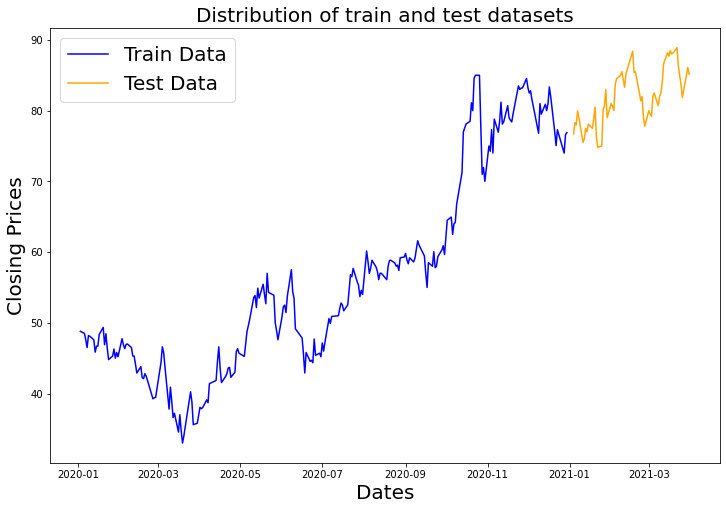

In [20]:
plt.figure(figsize=(12,8))
plt.plot(df_train['Price'],color='blue', label='Train Data')
plt.plot(df_test['Price'],color='orange', label='Test Data')
plt.xlabel('Dates',fontsize=20)
plt.ylabel('Closing Prices',fontsize=20)
plt.legend(loc='upper left',fontsize=20)
plt.title('Distribution of train and test datasets',fontsize=20)
plt.show()

In [21]:
df_train

,Price,Open,High,Low,Difference
Date,,,,,
2020-01-03,48.80,48.25,49.45,46.50,0.55
2020-01-06,48.50,48.40,48.70,47.00,-0.30
2020-01-07,47.60,48.35,49.00,46.90,-0.90
2020-01-08,46.50,47.50,47.50,46.00,-1.10
2020-01-09,48.20,46.55,48.50,46.05,1.70
...,...,...,...,...,...
2020-12-22,75.05,78.50,79.45,75.00,-1.95
2020-12-23,77.30,76.50,78.00,75.05,2.25
2020-12-28,74.00,77.00,77.30,74.00,-3.30


In [22]:
df_test

,Price,Open,High,Low,Difference
Date,,,,,
2021-01-04,76.70,76.90,78.10,76.00,-0.20
2021-01-05,78.30,76.65,78.90,76.20,1.60
2021-01-06,78.00,77.60,78.90,77.00,-0.30
2021-01-07,79.95,76.60,80.40,76.60,1.95
2021-01-08,79.00,79.45,79.90,76.30,-0.95
2021-01-11,75.50,76.70,77.20,73.80,-3.50
2021-01-12,76.00,74.55,78.00,73.20,0.50
2021-01-13,77.50,76.05,78.00,75.50,1.50
2021-01-14,77.00,78.00,78.50,75.80,-0.50


## ARIMA Model

In [23]:
 arima_model = pm.auto_arima(df_train.Price, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [25]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  239
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -511.777
Date:                Thu, 23 Jun 2022   AIC                           1027.554
Time:                        13:02:19   BIC                           1034.499
Sample:                             0   HQIC                          1030.353
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1181      0.135      0.876      0.381      -0.146       0.382
sigma2         4.3179      0.317     13.621      0.000       3.697       4.939
Ljung-Box (Q):                       35.75   Jarque-

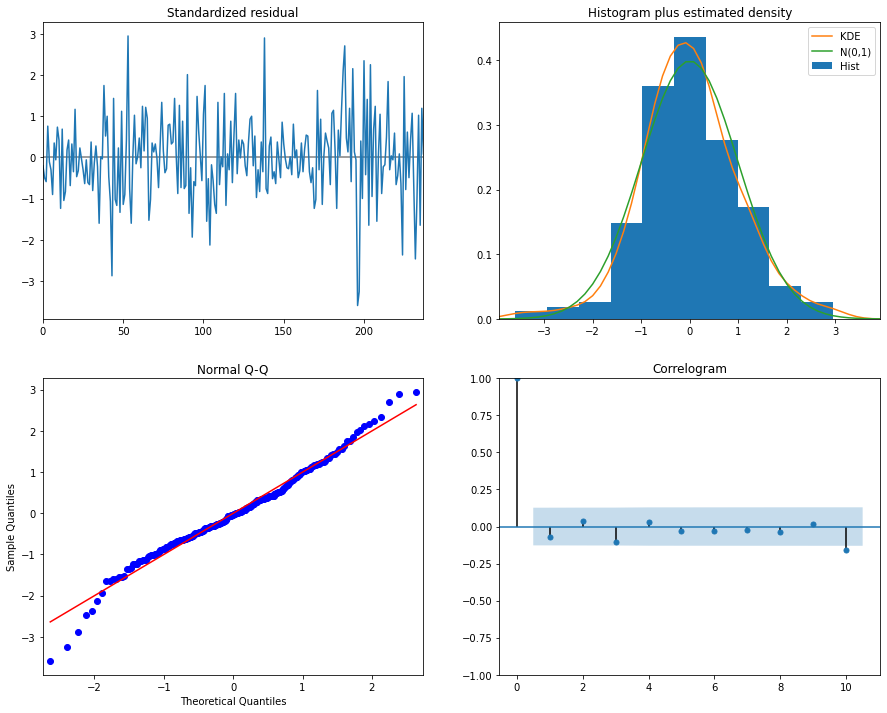

In [26]:
arima_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [28]:
arima = statsmodels.tsa.arima.model.ARIMA(df_train.Price,order=(0, 1, 0))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [29]:
arima_fit = arima.fit()

In [30]:
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  239
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -512.161
Date:                Thu, 23 Jun 2022   AIC                           1026.321
Time:                        13:02:31   BIC                           1029.794
Sample:                             0   HQIC                          1027.721
                                - 239                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.3319      0.319     13.589      0.000       3.707       4.957
Ljung-Box (Q):                       35.75   Jarque-Bera (JB):                12.50
Prob(Q):                              0.66   Pr

In [31]:
y_pred = arima_model.predict(len(df_test['Price']))

In [32]:
y_pred

array([77.01806723, 77.13613445, 77.25420168, 77.37226891, 77.49033613,
       77.60840336, 77.72647059, 77.84453782, 77.96260504, 78.08067227,
       78.1987395 , 78.31680672, 78.43487395, 78.55294118, 78.6710084 ,
       78.78907563, 78.90714286, 79.02521008, 79.14327731, 79.26134454,
       79.37941176, 79.49747899, 79.61554622, 79.73361345, 79.85168067,
       79.9697479 , 80.08781513, 80.20588235, 80.32394958, 80.44201681,
       80.56008403, 80.67815126, 80.79621849, 80.91428571, 81.03235294,
       81.15042017, 81.26848739, 81.38655462, 81.50462185, 81.62268908,
       81.7407563 , 81.85882353, 81.97689076, 82.09495798, 82.21302521,
       82.33109244, 82.44915966, 82.56722689, 82.68529412, 82.80336134,
       82.92142857, 83.0394958 , 83.15756303, 83.27563025, 83.39369748,
       83.51176471, 83.62983193, 83.74789916, 83.86596639, 83.98403361])

In [33]:
fc = len(df_test['Price'])
fc_series = pd.Series(y_pred,index=df_test['Price'].index)

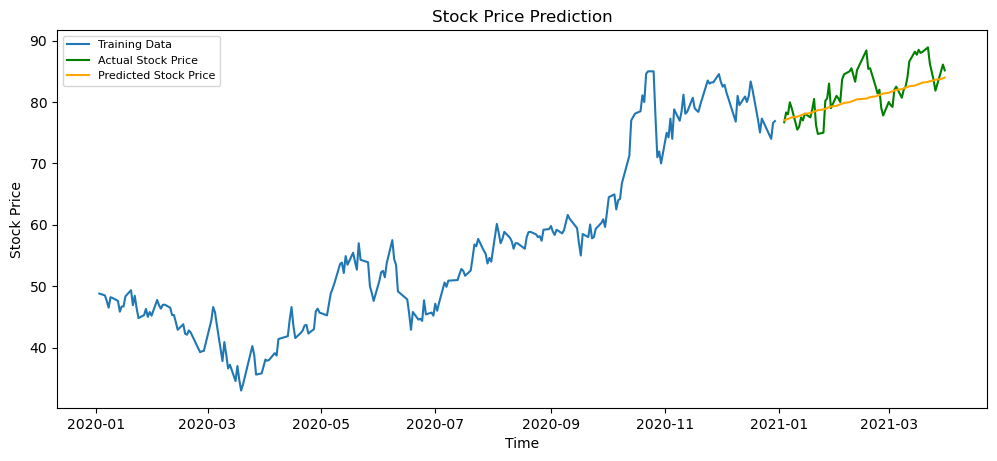

In [34]:
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df_train.Price,label='Training Data')
plt.plot(df_test.Price,color='green',label='Actual Stock Price')
plt.plot(fc_series,color='orange',label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [35]:
fc_series

Date
2021-01-04    77.018067
2021-01-05    77.136134
2021-01-06    77.254202
2021-01-07    77.372269
2021-01-08    77.490336
2021-01-11    77.608403
2021-01-12    77.726471
2021-01-13    77.844538
2021-01-14    77.962605
2021-01-15    78.080672
2021-01-18    78.198739
2021-01-19    78.316807
2021-01-20    78.434874
2021-01-21    78.552941
2021-01-22    78.671008
2021-01-25    78.789076
2021-01-26    78.907143
2021-01-27    79.025210
2021-01-28    79.143277
2021-01-29    79.261345
2021-02-01    79.379412
2021-02-02    79.497479
2021-02-03    79.615546
2021-02-04    79.733613
2021-02-05    79.851681
2021-02-08    79.969748
2021-02-09    80.087815
2021-02-10    80.205882
2021-02-11    80.323950
2021-02-12    80.442017
2021-02-17    80.560084
2021-02-18    80.678151
2021-02-19    80.796218
2021-02-22    80.914286
2021-02-23    81.032353
2021-02-24    81.150420
2021-02-25    81.268487
2021-02-26    81.386555
2021-03-01    81.504622
2021-03-02    81.622689
2021-03-03    81.740756
2021-03-04 

In [36]:
mape = np.mean(np.abs(fc-df_test['Price'])/np.abs(df_test['Price']))
print(mape)

0.26570989073779033


In [37]:
 mean_absolute_error(df_test.Price, y_pred)

2.446253501400523

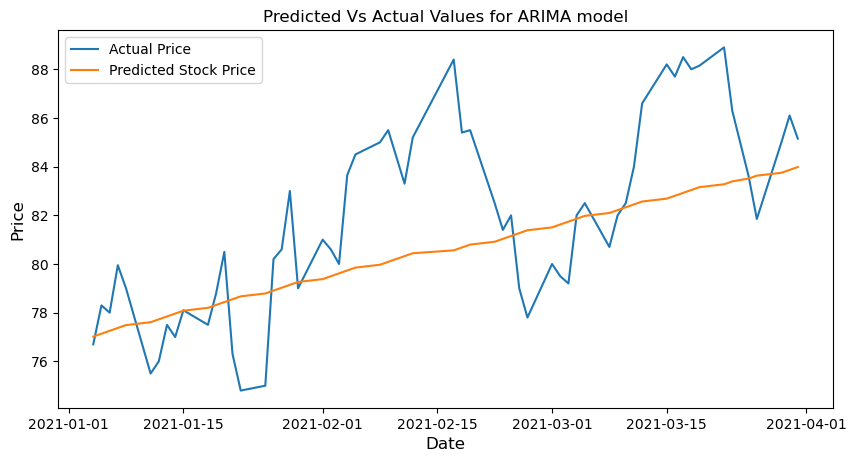

In [38]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(df_test.Price,label='Actual Price')
plt.plot(fc_series,label='Predicted Stock Price')
plt.title('Predicted Vs Actual Values for ARIMA model')
plt.xlabel('Date',fontsize=12)
plt.ylabel('Price',fontsize=12)
plt.legend(loc='upper left',fontsize=10)
plt.show()

## Time Series Cross Validation

Observations: 151
Training Observations: 77
Testing Observations: 74


<Figure size 432x288 with 0 Axes>

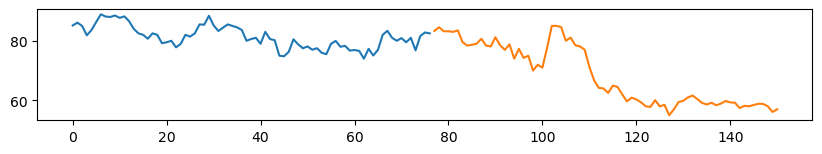

Observations: 225
Training Observations: 151
Testing Observations: 74


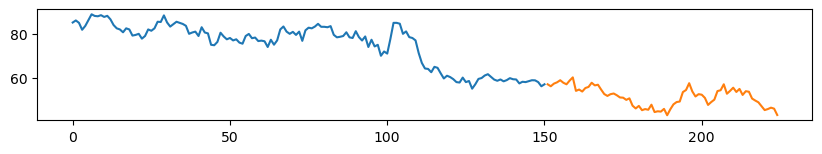

Observations: 299
Training Observations: 225
Testing Observations: 74


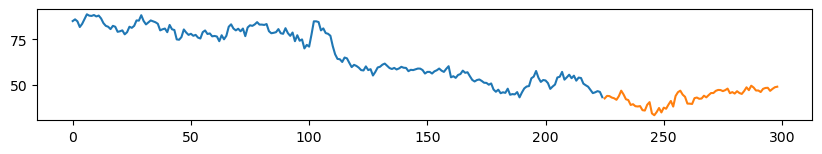

In [39]:

from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot

X = df.Price
splits = TimeSeriesSplit(n_splits=3)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.figure(figsize=(10,5),dpi=100)
    pyplot.subplot(310 + index)
    pyplot.plot(train)
    pyplot.plot([None for i in train] + [x for x in test])
    index += 1
    pyplot.show()

In [40]:
from matplotlib import pyplot

X = df.Price
n_train = 249
n_records = len(X)
for i in range(n_train, n_records):
	train, test = X[0:i], X[i:i+1]
	print('train=%d, test=%d' % (len(train), len(test)))

train=249, test=1
train=250, test=1
train=251, test=1
train=252, test=1
train=253, test=1
train=254, test=1
train=255, test=1
train=256, test=1
train=257, test=1
train=258, test=1
train=259, test=1
train=260, test=1
train=261, test=1
train=262, test=1
train=263, test=1
train=264, test=1
train=265, test=1
train=266, test=1
train=267, test=1
train=268, test=1
train=269, test=1
train=270, test=1
train=271, test=1
train=272, test=1
train=273, test=1
train=274, test=1
train=275, test=1
train=276, test=1
train=277, test=1
train=278, test=1
train=279, test=1
train=280, test=1
train=281, test=1
train=282, test=1
train=283, test=1
train=284, test=1
train=285, test=1
train=286, test=1
train=287, test=1
train=288, test=1
train=289, test=1
train=290, test=1
train=291, test=1
train=292, test=1
train=293, test=1
train=294, test=1
train=295, test=1
train=296, test=1
train=297, test=1
train=298, test=1


In [41]:
x = df_final['Price']
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(0, 1, 0)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-03-31  85.15       86.225589


In [42]:
import warnings
from math import sqrt

# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(0, 1, 0)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Price  predictions_wf
Date                             
2021-02-17  88.40       85.335821
2021-02-18  85.40       88.547212
2021-02-19  85.50       85.535556
2021-02-22  82.50       85.635424
2021-02-23  81.40       82.623897
2021-02-24  82.00       81.519414
2021-02-25  79.00       82.121168
2021-02-26  77.80       79.109818
2021-03-01  80.00       77.905072
2021-03-02  79.50       80.112635
2021-03-03  79.20       79.610432
2021-03-04  82.00       79.308961
2021-03-05  82.50       82.118571
2021-03-08  80.70       82.619929
2021-03-09  82.00       80.813121
2021-03-10  82.50       82.117314
2021-03-11  84.00       82.618662
2021-03-12  86.60       84.123509
2021-03-15  88.20       86.732168
2021-03-16  87.70       88.337282
2021-03-17  88.50       87.835069
2021-03-18  88.00       88.637370
2021-03-19  88.15       88.135172
2021-03-22  88.90       88.285223
2021-03-23  86.30       89.037329
2021-03-25  83.60       86.427986
2021-03-26  81.85       83.718367
2021-03-29  85

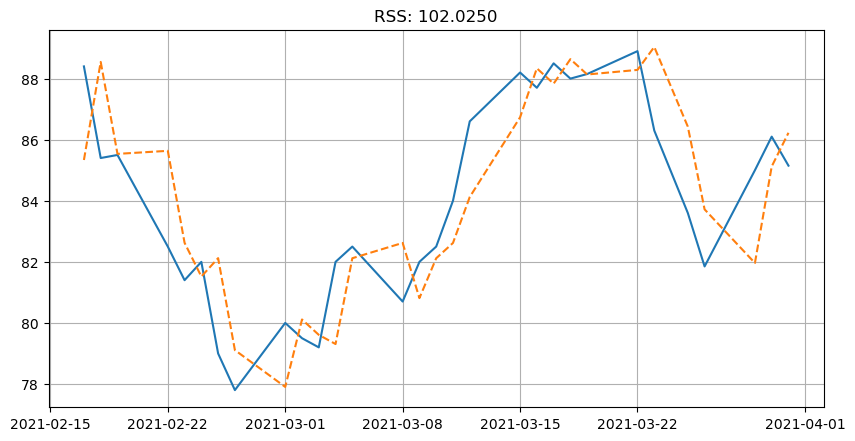

Test RMSE for ARIMA with Walk-Forward Validation:  1.8441351600114722


In [43]:
plt.figure(figsize=(10,5),dpi=100)
plt.plot(test_['Price'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Price'])**2))
plt.grid(True);plt.show()
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

In [44]:
mape = np.mean(np.abs(prediction-test.values)/np.abs(test.values))
print(mape)

0.018182906676333585


# LSTM Model

In [45]:
df = timeseries_preprocessing(df_arg)

<ipython-input-5-f3766a7b7a0d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].str.replace('K', '')
<ipython-input-5-f3766a7b7a0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_data['Vol.'] = k_data['Vol.'].apply(pd.to_numeric)
<ipython-input-5-f3766a7b7a0d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [46]:
df

,Date,Price,Open,High,Low
298,2020-01-03,48.80,48.25,49.45,46.50
297,2020-01-06,48.50,48.40,48.70,47.00
296,2020-01-07,47.60,48.35,49.00,46.90
295,2020-01-08,46.50,47.50,47.50,46.00
294,2020-01-09,48.20,46.55,48.50,46.05
...,...,...,...,...,...
4,2021-03-25,83.60,85.20,87.30,82.10
3,2021-03-26,81.85,84.00,84.60,80.70
2,2021-03-29,85.00,80.00,86.00,79.00
1,2021-03-30,86.10,85.15,86.75,84.60


In [47]:
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [48]:
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

In [49]:
train_test_boundary

60

In [50]:
date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

In [51]:
df = df.set_index('Date')

In [52]:
df

,Price,Open,High,Low,Year
Date,,,,,
2020-01-03,48.80,48.25,49.45,46.50,2020
2020-01-06,48.50,48.40,48.70,47.00,2020
2020-01-07,47.60,48.35,49.00,46.90,2020
2020-01-08,46.50,47.50,47.50,46.00,2020
2020-01-09,48.20,46.55,48.50,46.05,2020
...,...,...,...,...,...
2021-03-25,83.60,85.20,87.30,82.10,2021
2021-03-26,81.85,84.00,84.60,80.70,2021
2021-03-29,85.00,80.00,86.00,79.00,2021


In [53]:
#removing the Year column
df = df.drop(columns = ['Year'])

In [54]:
#global variables
n_steps = 3
n_features = 1


In [55]:
#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

In [56]:
#defining the training dataframe
train_df = df[:-train_test_boundary]
    
#defining the testing dataframe
test_df = df[-train_test_boundary:]

In [57]:
train_df.shape

(239, 4)

In [58]:
test_df.shape

(60, 4)

In [59]:
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((3,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

In [60]:
#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(train_df, n_steps)
    
#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [61]:
X_train.shape,y_train.shape

((236, 3, 1), (236,))

In [62]:
X_test.shape,y_test.shape

((57, 3, 1), (57,))

In [63]:
# define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse', metrics=['mse'])
    
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features)) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features)
    
# fit model
history = model.fit(X_train, y_train, epochs=250, verbose=0, validation_data = (X_test, y_test))

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [64]:
#generating the predicted array using model.predict
forecast = []
y_hat = []

for time in range (len(df) - n_steps):
    X = df['Price'].to_numpy()
    pred = model.predict(X[time:time+n_steps].reshape(1,3,1))
    forecast.append(pred)

y_hat = np.array(forecast)

y_hat = np.append(y_hat[:, 0], np.zeros((y_hat[:, 0].shape[0], 3)), axis=1) 
y_hat = scaler.inverse_transform(y_hat) #converting the normalized data back to its orginal 

df = scaler.inverse_transform(df)

df_final = pd.DataFrame()
df_final['Actual Price'], df_final['Predicted Price'], df_final["Date"] = df[3:, 0], y_hat[:, 0], date_arr[3:]
df_final = df_final.set_index('Date')

C:\Users\rames\AppData\Roaming\Python\Python38\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [65]:
df_final

,Actual Price,Predicted Price
Date,,
2020-01-08,46.50,48.331590
2020-01-09,48.20,47.712759
2020-01-10,48.10,47.147624
2020-01-13,47.60,47.119095
2020-01-14,45.85,47.888100
...,...,...
2021-03-25,83.60,87.284049
2021-03-26,81.85,86.302578
2021-03-29,85.00,83.942423


In [66]:
#calculate rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
df_final = df_final.dropna(axis=0)
rmse = sqrt(mean_squared_error(df_final['Actual Price'], df_final['Predicted Price']))
print("Root Mean Squared Error is", rmse)

df_final_copy = df_final

Root Mean Squared Error is 2.6753822440355974


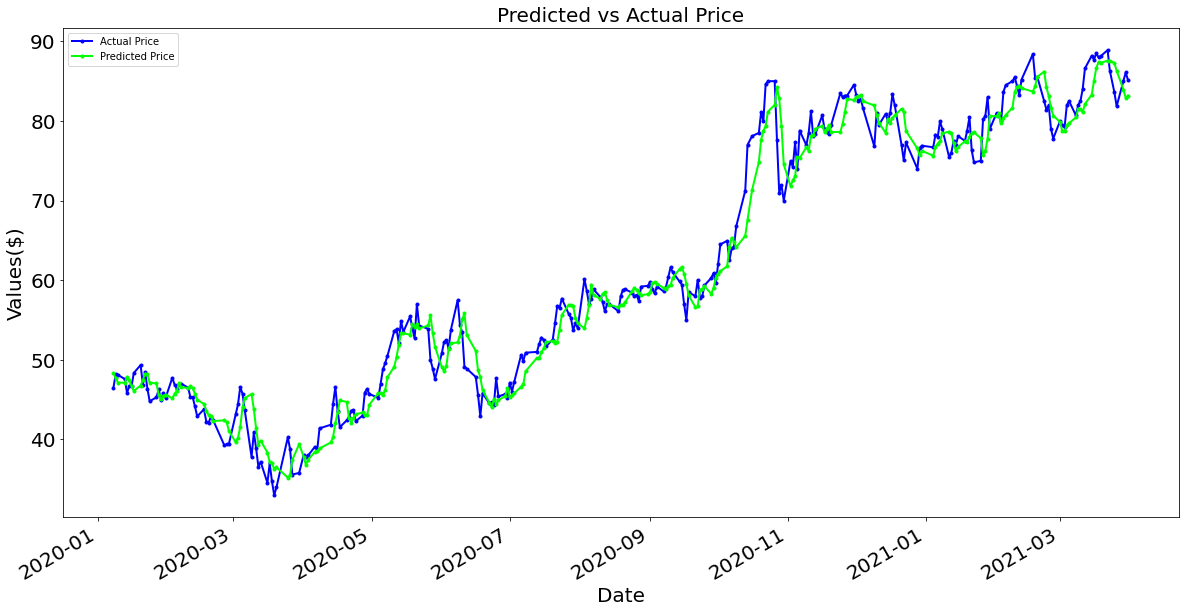

In [67]:
df_final[['Actual Price','Predicted Price']].plot(figsize=(20,10),linewidth=2,marker='.',colormap='brg',fontsize=20);
plt.xlabel('Date',fontsize=20);
plt.ylabel('Values($)',fontsize=20);
plt.title('Predicted vs Actual Price',fontsize = 20)
plt.show() 

<Figure size 432x288 with 0 Axes>

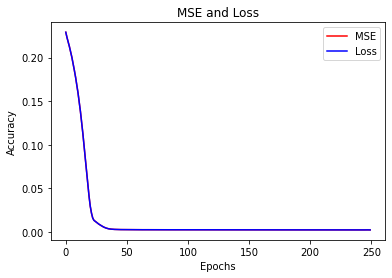

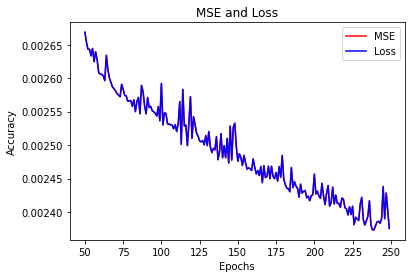

<Figure size 432x288 with 0 Axes>

In [68]:
mse=history.history['mse']
loss=history.history['loss']

epochs=range(len(loss))

plt.plot(epochs, mse, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])


plt.figure()

epochs_zoom = epochs[50:]
mse_zoom = mse[50:]
loss_zoom = loss[50:]

plt.plot(epochs_zoom, mse_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MSE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MSE", "Loss"])

plt.figure()


In [69]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

def implement_bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(1, len(data)):
        if data.iloc[i-1] > lower_bb.iloc[i-1] and data.iloc[i] < lower_bb.iloc[i]:
            if signal != 1:
                buy_price.append(data.iloc[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data.iloc[i-1] < upper_bb.iloc[i-1] and data.iloc[i] > upper_bb.iloc[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data.iloc[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

In [70]:
investment_returns = []
sma_params = []
bb_params = []
        
for sma_param in np.linspace(10, 100, 10).astype(int):
    df_final = df_final_copy
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(10, 100, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)

        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']
        bb_signal = pd.DataFrame(bb_signal).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)
        
        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 100000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if strategy['bb_signal'].iloc[i] == None:
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 100000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)
        
max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}". 
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $104476.5 with sma of 30 using a bollinger parameter 30


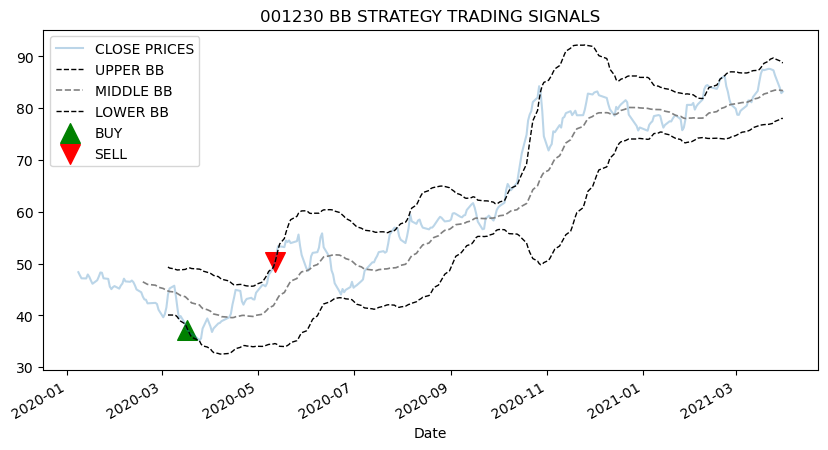

In [71]:
df_final['sma'] = sma(df_final['Predicted Price'], 30)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 40)
buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
buy_price.insert(0, None)
sell_price.insert(0, None)
bb_signal.insert(0, None)
plt.figure(figsize=(10,5),dpi=100)
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('001230 BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()